Удалила "2 Зрелый почерк-(обычный почерк)-2.jpg" (там печатный текст)

# Config

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
cd drive/MyDrive/Colab\ Notebooks/mest

/content/drive/MyDrive/Colab Notebooks/mest


In [55]:
DATA = "bin"
DATA_POS = f"{DATA}/1"
DATA_NEG = f"{DATA}/0"

THRESHOLD = 0.999 # доля белого
# THRESHOLD = 0.994
BATCH_SIZE = 8
PATH = "m.pth"
import torch
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import accuracy_score
from torchvision import datasets, models, transforms
from time import time

from src.functions import *
from src.dataset import *
from src.train import *

print(f"{DEVICE = }")

DEVICE = device(type='cuda')


In [4]:
# seed_everything(42)
"seed_everything(42)"

'seed_everything(42)'

# torchvision.transforms

In [5]:
# data_transform = transforms.Compose([
#     # transforms.Resize(size=(224, 224)),
#     transforms.RandomCrop(300),
#     # Flip the images randomly on the horizontal
#     # transforms.RandomHorizontalFlip(p=1), # p = probability of flip, 0.5 = 50% chance
#     # Turn the image into a torch.Tensor
#     transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
# ])


# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [6]:
# files_names = sorted(os.listdir(IMG_POS))
# image_paths  = [os.path.join(IMG_POS, i) for i in files_names]

# plot_transformed_images(image_paths, transform=data_transform)

# Dataset

In [99]:

class Positive_Dataset(Dataset):
    def __init__(
        self, images_dir, augmentation, transform, deterministic=True, seed=42
    ):
        self.augmentation = augmentation
        self.transform = transform
        self.deterministic = deterministic

        self.files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in self.files_names]

        self.real_len = len(self.files_names)
        self.required_len = self.augmentation * self.real_len

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            # for i in range(self.required_len):
            i = 0
            while len(self.X) < self.required_len:
                image = Image.open(self.image_paths[i % self.real_len])
                i += 1
                transformed_image = self.transform(image)

                x, col = np.unique(transformed_image.max(dim = 0)[0], return_counts = True)
                ones = col[np.where(x == 1)[0]][0]
                dol = ones / col.sum() # доля белого
                if dol < THRESHOLD:
                    self.X.append((transformed_image, 1))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                image = Image.open(self.image_paths[idx % self.real_len])
                return self.transform(image), 1
        else:
            raise IndexError


class Negative_Dataset(Dataset):
    def __init__(
        self, images_dir, augmentation, transform, deterministic=True, seed=42
    ):
        self.augmentation = augmentation
        self.transform = transform
        self.deterministic = deterministic

        self.files_names = sorted(os.listdir(images_dir))
        self.image_paths = [os.path.join(images_dir, i) for i in self.files_names]

        self.real_len = len(self.files_names)
        self.required_len = self.augmentation * self.real_len

        if self.deterministic:
            seed_everything(seed)
            self.X = []

            # for i in range(self.required_len):
            i = 0
            while len(self.X) < self.required_len:
                image = Image.open(self.image_paths[i % self.real_len])
                i += 1
                image = Image.open(self.image_paths[i % self.real_len])
                transformed_image = self.transform(image)

                x, col = np.unique(transformed_image.max(dim = 0)[0], return_counts = True)
                ones = col[np.where(x == 1)[0]][0]
                dol = ones / col.sum() # доля белого
                if dol < THRESHOLD:
                    if i == 1:
                        print(transformed_image)
                    self.X.append((transformed_image, 0))

    def __len__(self):
        return self.required_len

    def __getitem__(self, idx):
        if idx < len(self):

            if self.deterministic:
                return self.X[idx]
            else:
                image = Image.open(self.image_paths[idx % self.real_len])
                return self.transform(image), 0
        else:
            raise IndexError

In [100]:
# tranf = transforms.Compose([
#         # transforms.Resize(256), # размер каждой картинки будет приведен к 256*256
#         # transforms.CenterCrop(224), # у картинки будет вырезан центральный кусок размера 224*224
#         transforms.RandomCrop(224)
#         # transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
#         transforms.ToTensor(), # картинка из питоновского массива переводится в формат torch.Tensor
#         # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # значения пикселей картинки нормализуются
#     ])

In [101]:
data_transform = transforms.Compose([
    transforms.RandomCrop(300),
    # transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
])

# pos_dataset = Positive_Dataset(DATA_POS, augmentation=22, transform=data_transform) # 11
# print(f"Positive: {len(pos_dataset)}    ({pos_dataset.real_len})")

neg_dataset = Negative_Dataset(DATA_NEG, augmentation=2, transform=data_transform) # 1
print(f"Negative: {len(neg_dataset)}    ({neg_dataset.real_len})")

dataset = torch.utils.data.ConcatDataset([pos_dataset, neg_dataset]) # подряд идут 1, потом 0
print(f"ConcatDataset: {len(dataset)}")

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])
Negative: 448    (224)
ConcatDataset: 932


In [72]:
x1 = neg_dataset

In [76]:
x1[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

In [68]:
x2 = neg_dataset

In [75]:
x2[0][0]

tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]],

        [[1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 0., 0.,  ..., 1., 1., 1.],
         ...,
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.],
         [1., 1., 1.,  ..., 1., 1., 1.]]])

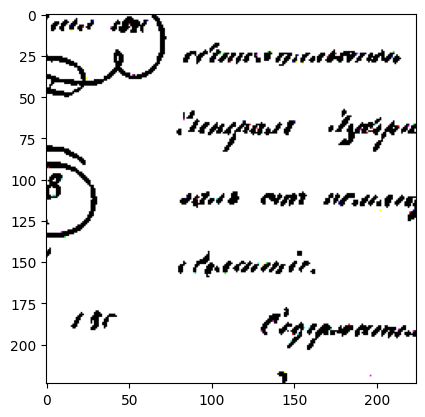

In [106]:
plt.imshow(np.transpose(x1[2][0], (1, 2, 0)))

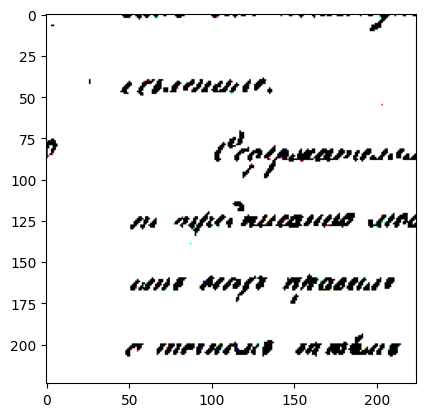

In [107]:
plt.imshow(np.transpose(x2[2][0], (1, 2, 0)))

In [47]:
# seed_everything(42)

# n = []

# l = len(pos_dataset.files_names)
# for i, (img, cl) in enumerate(pos_dataset):
#     fname = pos_dataset.files_names[i % l]
#     file, ext = os.path.splitext(fname)
#     # print(fname)
#     n.append(f"{file}_{i // l}{ext}")
#     # print(f"{file}#{i // l}{ext}\n")
#     # img.save(os.path.join(DATA_POS, f"{file}#{i // l}{ext}"))

In [48]:
# в тренировочную выборку отнесем 80% всех картинок

train_size = int(len(dataset) * 0.8)
# в валидационную — остальные 20%
val_size = len(dataset) - train_size

seed_everything(42)
train_dataset, test_dataset = torch.utils.data.random_split(
                    dataset, [train_size, val_size])

print(f"Train: {len(train_dataset)}\n Test: {len(test_dataset)}")

Train: 745
 Test: 187


# Dataloader

In [49]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                          shuffle=False)

print(f"Train batches: {len(train_loader)}\n Test batches: {len(test_loader)}")

Train batches: 94
 Test batches: 24


In [50]:
pos_neg(train_loader)

{'1': 381, '0': 364, 'total': 745}

In [51]:
pos_neg(test_loader)

{'1': 103, '0': 84, 'total': 187}

torch.Size([8, 3, 224, 224]) tensor([1, 1, 0, 0, 1, 1, 1, 0])


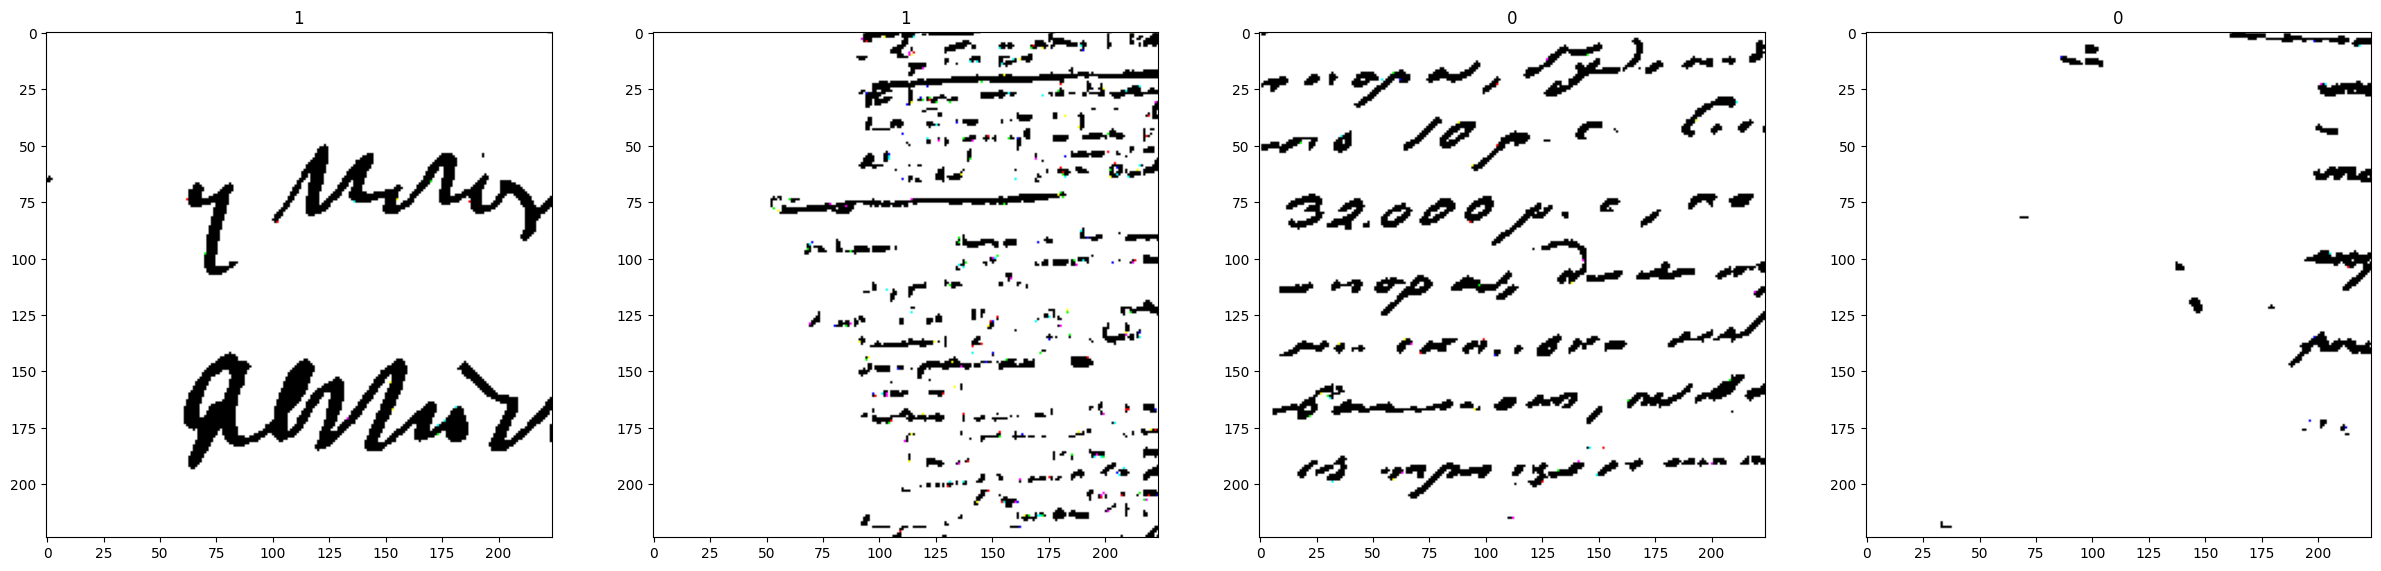

In [56]:
images, labels = next(iter(test_loader))
print(images.shape, labels)
show_images(images, labels)

# freeze_layers

In [57]:
def number_of_parameters(model):
    return f"{sum(p.numel() for p in model.parameters() if p.requires_grad)} parameters"

In [58]:
model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
# list(model.children())
# dir(model)
number_of_parameters(model)

'11689512 parameters'

In [59]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [60]:
num_layers = len(list(model.children()))
print(f"Число слоёв: {num_layers}")
num_classes = 2
print(f"Число классов: {num_classes}")

seed_everything(42)
model = create_model(model, num_layers - 1, num_classes).to(DEVICE)

Число слоёв: 10
Число классов: 2


In [61]:
number_of_parameters(model)

'1026 parameters'

In [62]:
model.fc

Linear(in_features=512, out_features=2, bias=True)

In [63]:
# for i, layer in enumerate(model.children()):
#     for param in layer.parameters():
#         if param.requires_grad:
#             print(i, layer, param.shape, param, param.requires_grad, sep = "\n")

In [64]:
# model.load_state_dict(torch.load(PATH, map_location=DEVICE))

# train

In [65]:
start_time = time()

seed_everything(42)

# выбираем функцию потерь
loss_fn = torch.nn.CrossEntropyLoss()

# выбираем алгоритм оптимизации и learning_rate.
# вы можете экспериментировать с разными значениями learning_rate
learning_rate = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# запустим обучение модели
# параметр n_epoch можно варьировать
model = train(model, train_loader, test_loader, loss_fn, optimizer, n_epoch=20)
torch.save(model.state_dict(), PATH)

print(f"# Время работы: {(time() - start_time):6.5f}s")

# Epoch: 1
# Эпоха 1/20: val лосс и accuracy: 0.7135813497006893 0.54010695
# Epoch: 2
# Эпоха 2/20: val лосс и accuracy: 0.6724805124104023 0.5828877
# Epoch: 3
# Эпоха 3/20: val лосс и accuracy: 0.6407458695272604 0.6096257
# Epoch: 4
# Эпоха 4/20: val лосс и accuracy: 0.6157463006675243 0.6524064
# Epoch: 5
# Эпоха 5/20: val лосс и accuracy: 0.595326496909062 0.657754
# Epoch: 6
# Эпоха 6/20: val лосс и accuracy: 0.5782152799268564 0.6737968
# Epoch: 7
# Эпоха 7/20: val лосс и accuracy: 0.5636093802750111 0.6737968
# Epoch: 8
# Эпоха 8/20: val лосс и accuracy: 0.5509651663402716 0.684492
# Epoch: 9
# Эпоха 9/20: val лосс и accuracy: 0.5398938208818436 0.7058824
# Epoch: 10
# Эпоха 10/20: val лосс и accuracy: 0.530106034129858 0.72727275
# Epoch: 11
# Эпоха 11/20: val лосс и accuracy: 0.5213803897301356 0.72727275
# Epoch: 12
# Эпоха 12/20: val лосс и accuracy: 0.5135439522564411 0.7326203
# Epoch: 13
# Эпоха 13/20: val лосс и accuracy: 0.5064596310257912 0.7379679
# Epoch: 14
# Эпох

In [25]:
# Epoch: 1
# Эпоха 1/20: val лосс и accuracy: 0.7135813025136789 0.54010695
# Epoch: 2
# Эпоха 2/20: val лосс и accuracy: 0.6724807061254978 0.5828877
# Epoch: 3
# Эпоха 3/20: val лосс и accuracy: 0.640745971351862 0.6096257
# Epoch: 4
# Эпоха 4/20: val лосс и accuracy: 0.6157463739315668 0.6524064
# Epoch: 5
# Эпоха 5/20: val лосс и accuracy: 0.595326562722524 0.657754
# Epoch: 6
# Эпоха 6/20: val лосс и accuracy: 0.5782153345644474 0.6737968
# Epoch: 7
# Эпоха 7/20: val лосс и accuracy: 0.5636094150443872 0.6737968
# Epoch: 8
# Эпоха 8/20: val лосс и accuracy: 0.550965204834938 0.684492
# Epoch: 9
# Эпоха 9/20: val лосс и accuracy: 0.5398938270906607 0.7058824
# Epoch: 10
# Эпоха 10/20: val лосс и accuracy: 0.5301060366133848 0.72727275
# Epoch: 11
# Эпоха 11/20: val лосс и accuracy: 0.5213803773125013 0.72727275
# Epoch: 12
# Эпоха 12/20: val лосс и accuracy: 0.5135439299046993 0.7326203
# Epoch: 13
# Эпоха 13/20: val лосс и accuracy: 0.5064596092949311 0.7379679
# Epoch: 14
# Эпоха 14/20: val лосс и accuracy: 0.5000172120829424 0.7379679
# Epoch: 15
# Эпоха 15/20: val лосс и accuracy: 0.49412737662593526 0.7486631
# Epoch: 16
# Эпоха 16/20: val лосс и accuracy: 0.4887168159087499 0.7486631
# Epoch: 17
# Эпоха 17/20: val лосс и accuracy: 0.4837249635408322 0.7486631
# Epoch: 18
# Эпоха 18/20: val лосс и accuracy: 0.47910131389896077 0.7486631
# Epoch: 19
# Эпоха 19/20: val лосс и accuracy: 0.47480348373452824 0.7540107
# Epoch: 20
# Эпоха 20/20: val лосс и accuracy: 0.47079556869963807 0.7593583

# Код визуализации

In [26]:
def show_images(images, labels, n = 4):
    # f, axes= plt.subplots(n//4, 4, figsize=(30,10))


    num_pic = min(len(images), n)
    width, height = 4, num_pic // 4 + 1

    # plt.figure(figsize=(6.4 * width, 6))

    for i in range(num_pic):

        if i % width == 0:
            plt.figure(figsize=(6.4 * width, 6))

        # plt.subplot(height, width, i + 1)
        plt.subplot(1, width, i % width + 1)

        img = images[i]
        img = np.transpose(img, (1, 2, 0))

        plt.imshow(img)
        if torch.is_tensor(labels[i]):
            title = labels[i].numpy()
        else:
            title = labels[i]

        x, col = np.unique(img.max(dim = 2)[0], return_counts = True)
        ones = col[np.where(x == 1)[0]][0]
        dol = ones / col.sum()
        title = f"{title:.6} (доля белого - {dol:.4})"
        plt.title(title)

        if i % width == width - 1:
            plt.tight_layout()
            plt.show()

    plt.show()

In [27]:
def show_result(model, dataset, threshold, greater = True, col = 8, seed = 42, sort = False):
    seed_everything(seed)

    loader = torch.utils.data.DataLoader(dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

    y_pred, y_true, y_prob, X = get_predictions(model, loader)

    if sort:
        s, indices = torch.sort(y_prob, descending=True)
        y_pred = y_pred[indices]
        y_prob = y_prob[indices]
        X = X[indices]

    if greater:
        idx = np.where(y_prob > threshold)[0]
    else:
        idx = np.where(y_prob < threshold)[0]


    sign = ">" if greater else "<"
    print(f"prob {sign} {threshold}\ncount : {len(idx)} out of {len(dataset)}")
    idx = idx[:col]
    print(f"pic idx : {list(idx)}")
    show_images(X[idx], y_prob[idx], n = col)

    return y_pred, y_true, y_prob, X

# eval

In [28]:
y_pred, y_true, y_prob, _ = get_predictions(model, train_loader)
accuracy_score(y_pred, y_true)
# 0.8013422818791947

0.8268456375838926

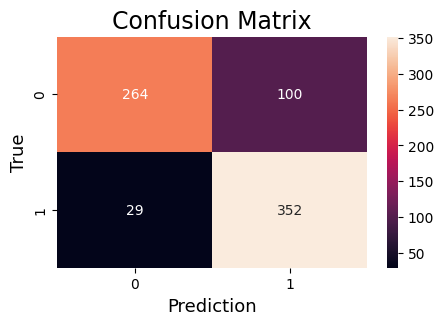

array([[264, 100],
       [ 29, 352]])

In [29]:
confusion_matrix(y_true, y_pred)

In [30]:
y_pred, y_true, y_prob, _ = get_predictions(model, test_loader)
accuracy_score(y_pred, y_true)
# 0.7593582887700535

0.7272727272727273

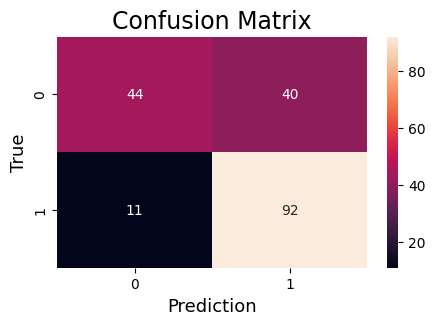

array([[44, 40],
       [11, 92]])

In [31]:
confusion_matrix(y_true, y_pred)

# show

0.9173553719008265


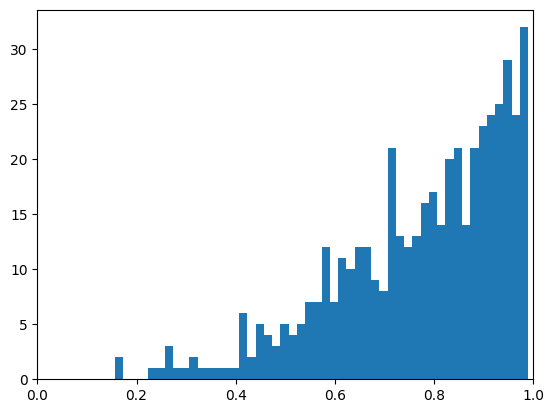

In [32]:
pos_loader = torch.utils.data.DataLoader(pos_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
print(accuracy_score(y_pred, y_true))

y_pred, y_true, y_prob, _ = get_predictions(model, pos_loader)
_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.9359504132231405

0.6875


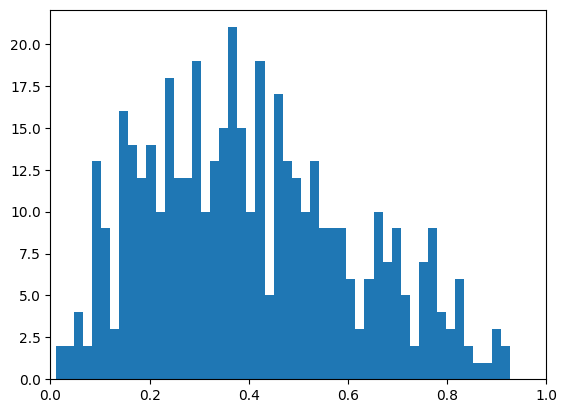

In [33]:
neg_loader = torch.utils.data.DataLoader(neg_dataset, batch_size=BATCH_SIZE,
                                           shuffle=False)

y_pred, y_true, y_prob, _ = get_predictions(model, neg_loader)
print(accuracy_score(y_pred, y_true))

_ = plt.hist(y_prob.numpy(), bins = 50)
plt.xlim((0,1))
plt.show()
# 0.6383928571428571

prob > 0.8
count : 255 out of 484
pic idx : [0, 1, 3, 5, 6, 7, 8, 9]


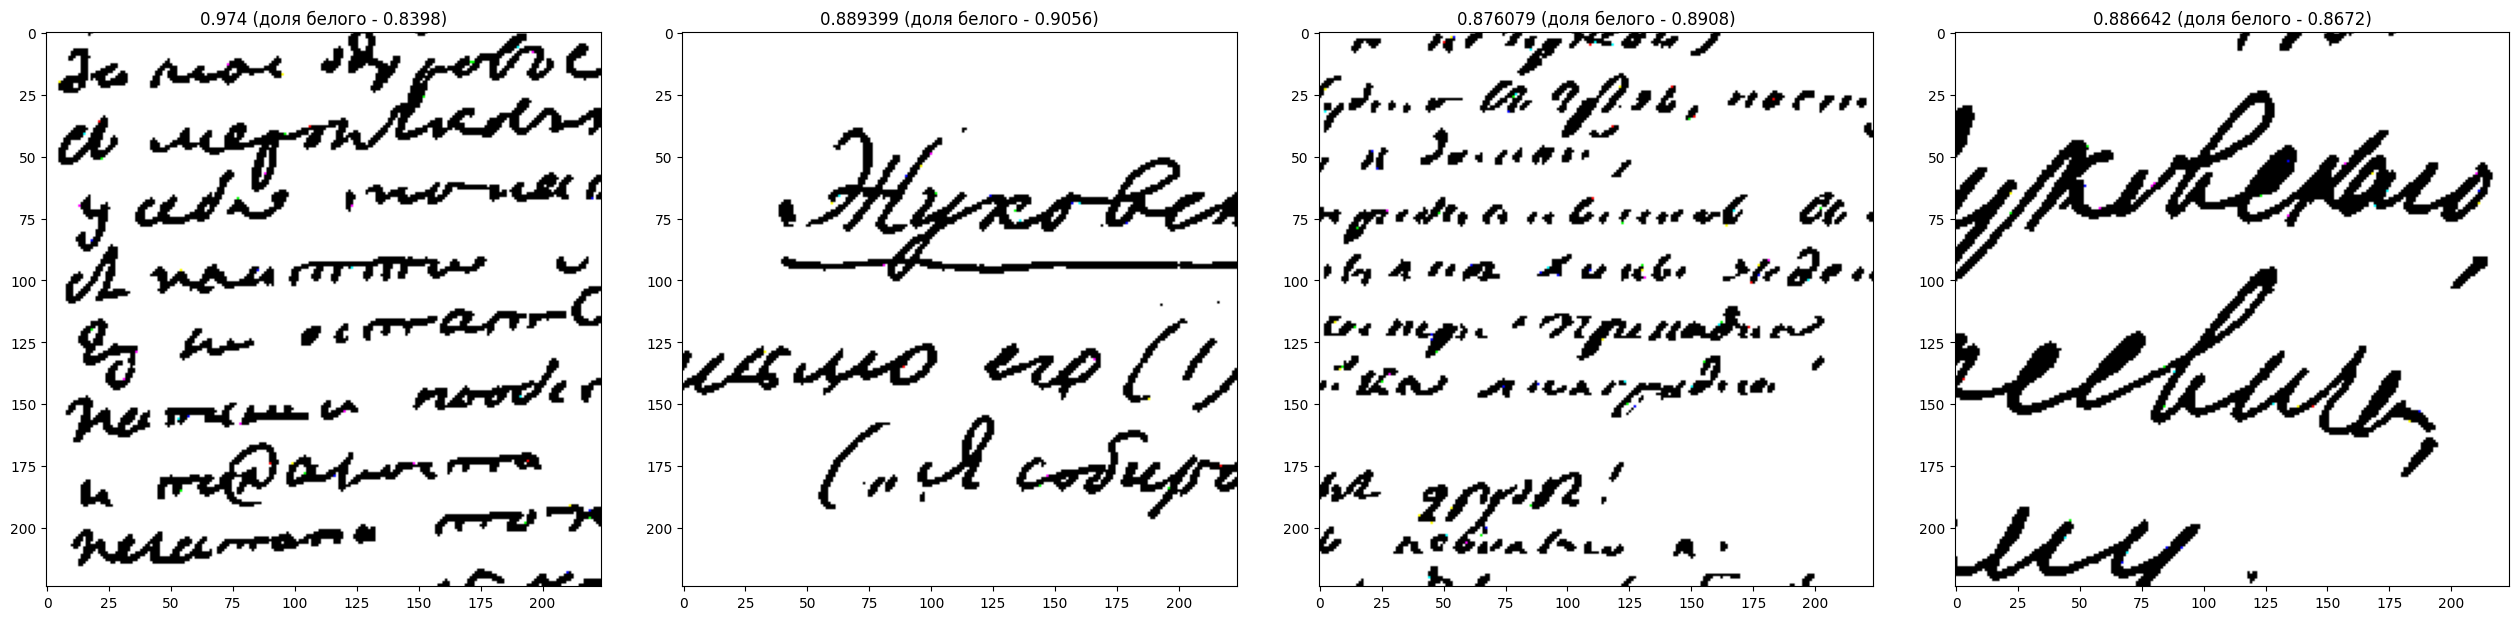

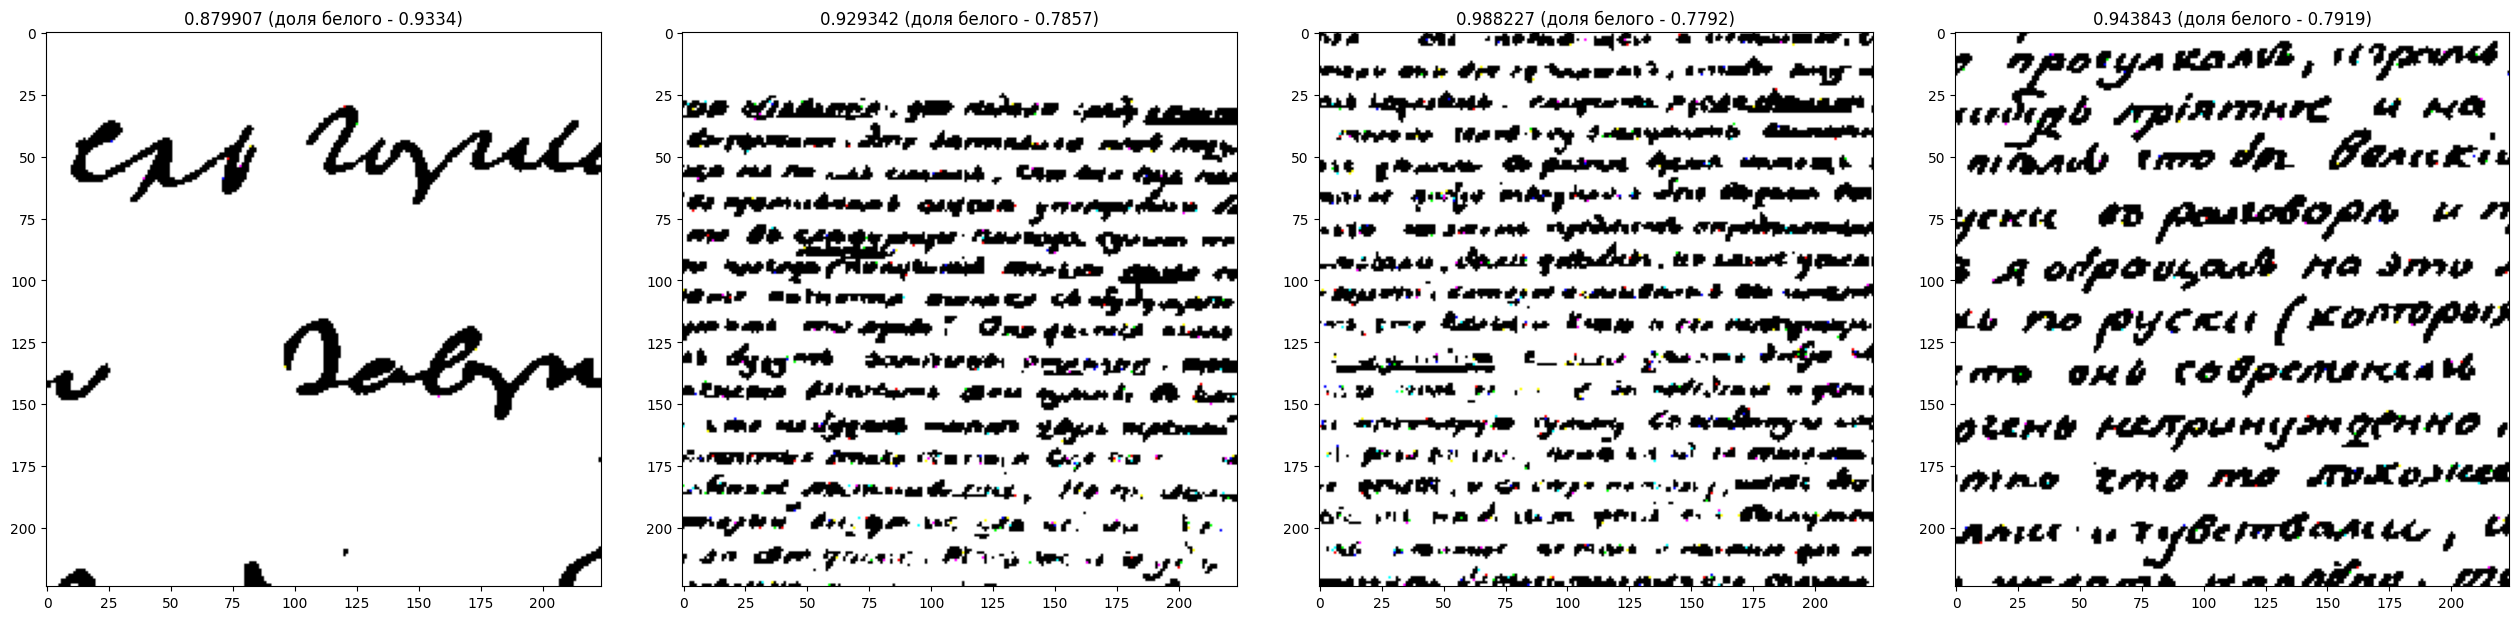

In [34]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.8, greater = True, col = 8)

prob < 0.6
count : 80 out of 484
pic idx : [2, 4, 10, 17, 20, 33, 40, 45]


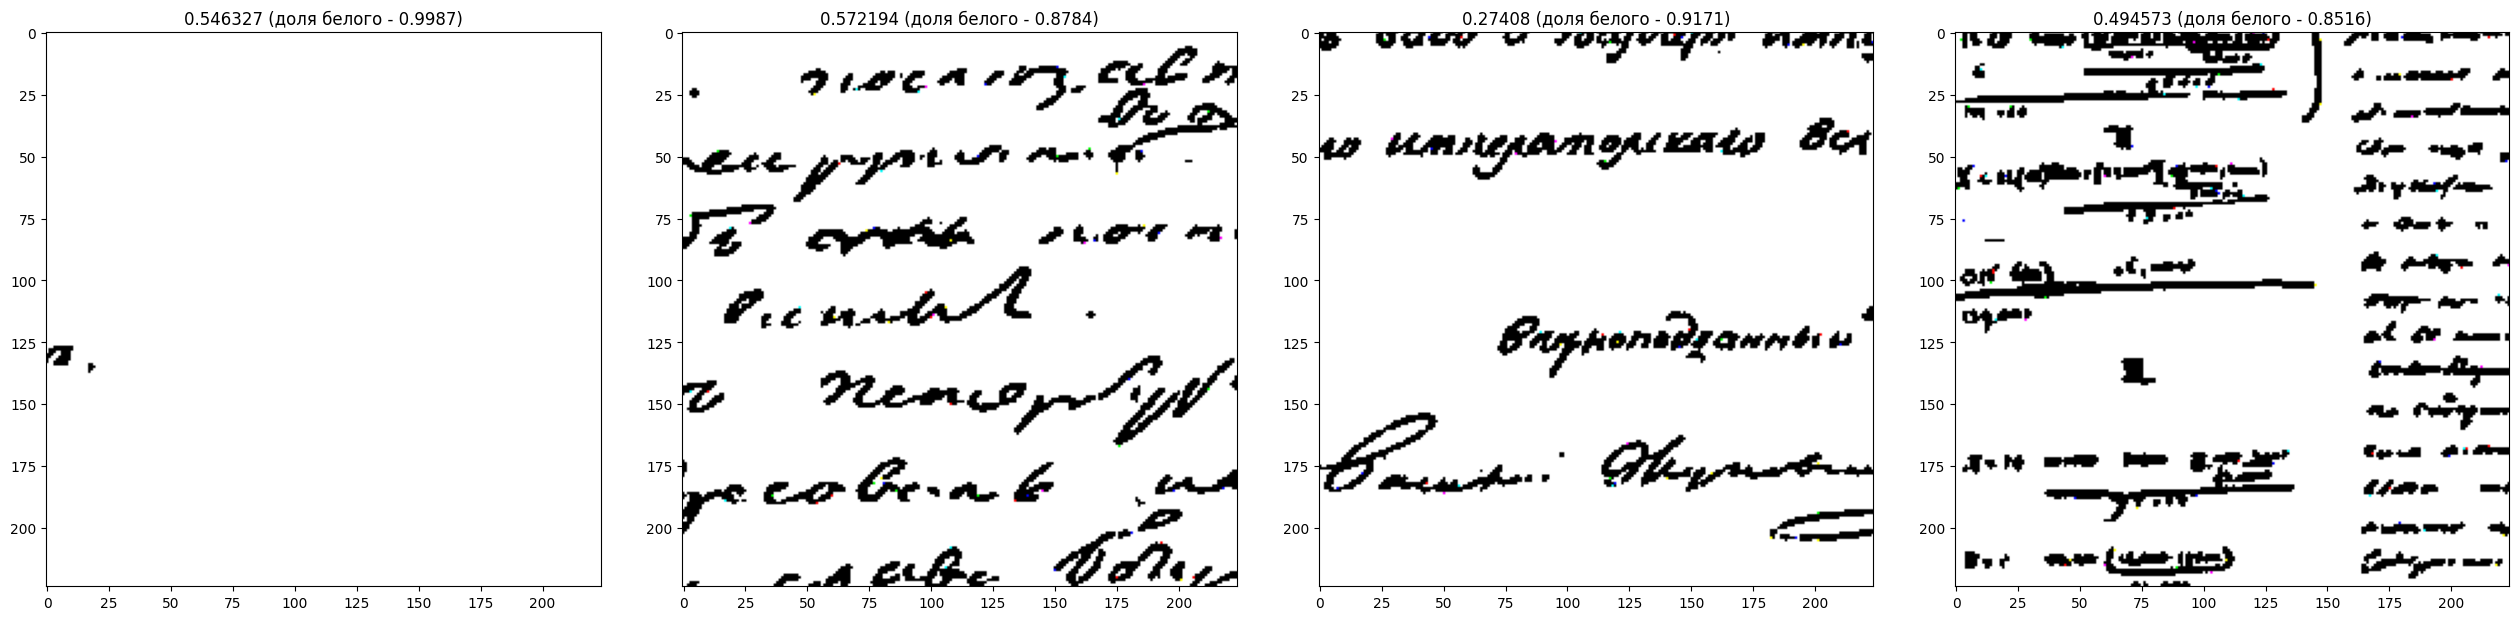

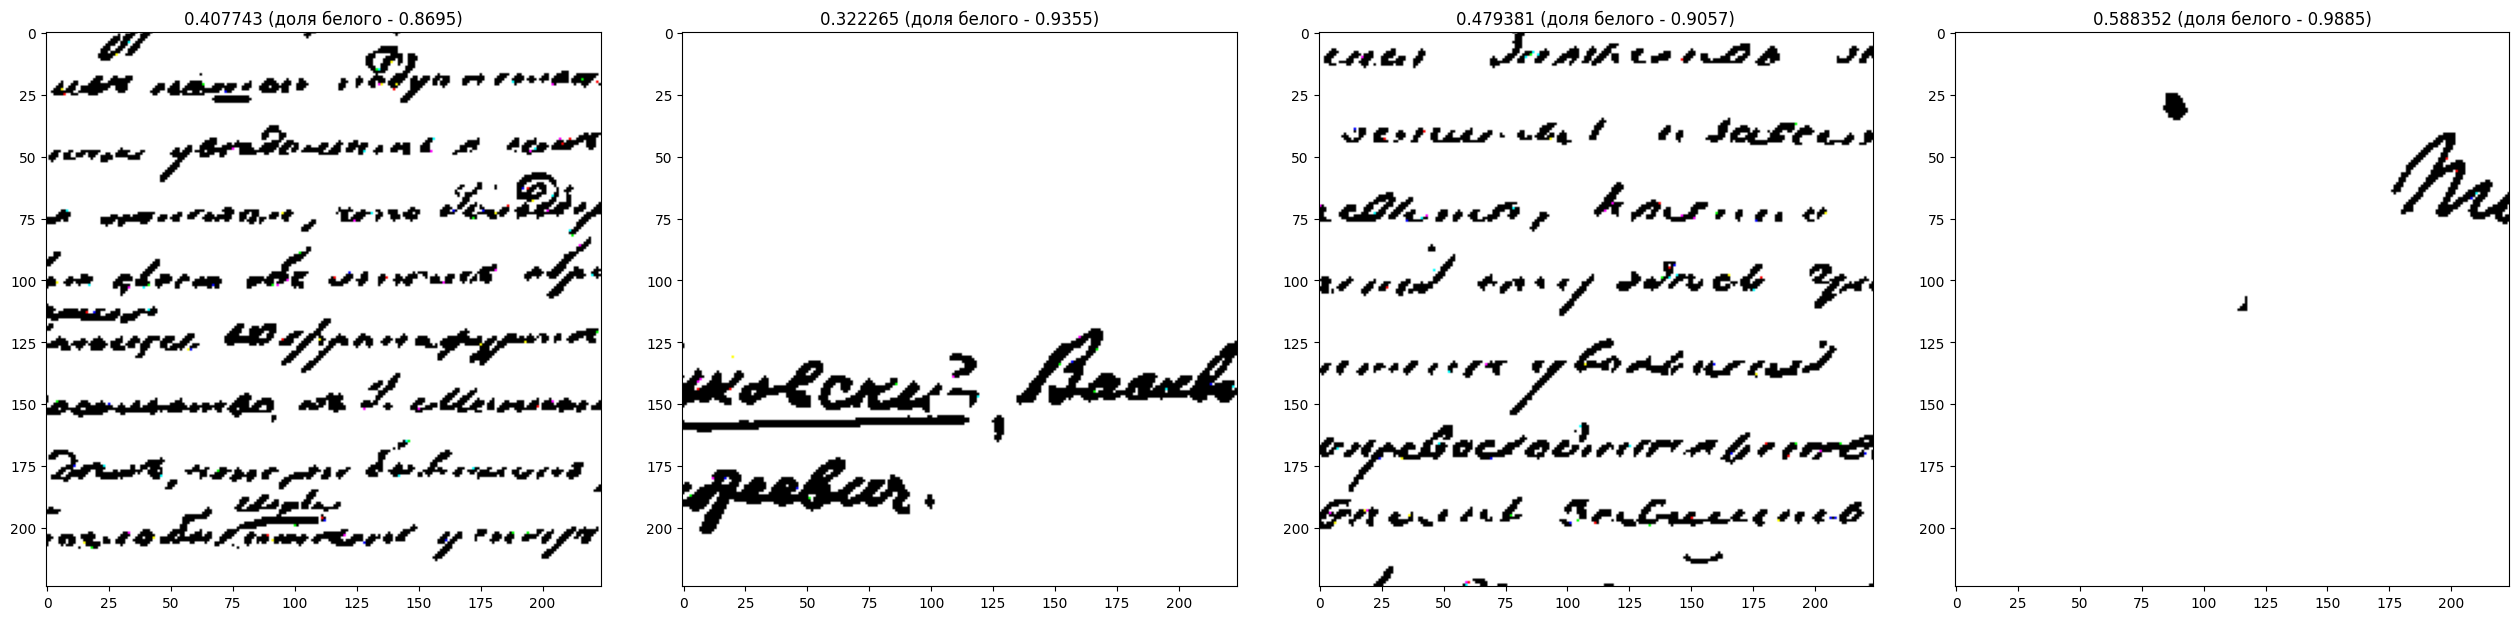

In [35]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0.6, greater = False, col = 8)

In [36]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.3, greater = False, col = 24, seed = 41)

Output hidden; open in https://colab.research.google.com to view.

prob > 0.79
count : 20 out of 448
pic idx : [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]


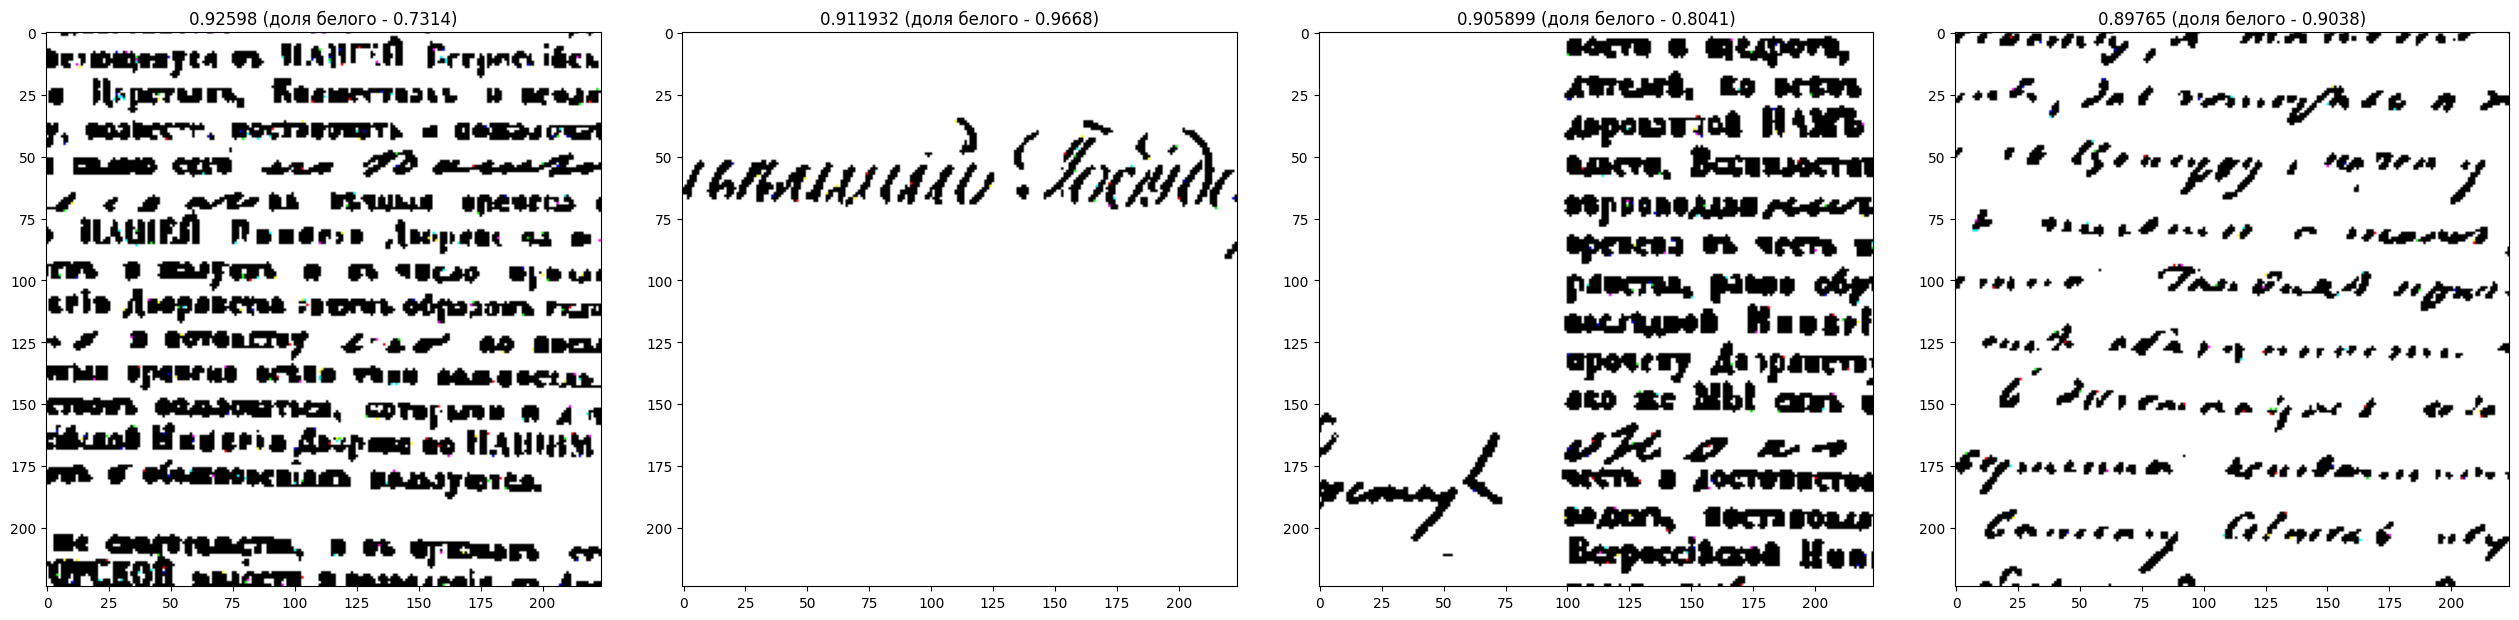

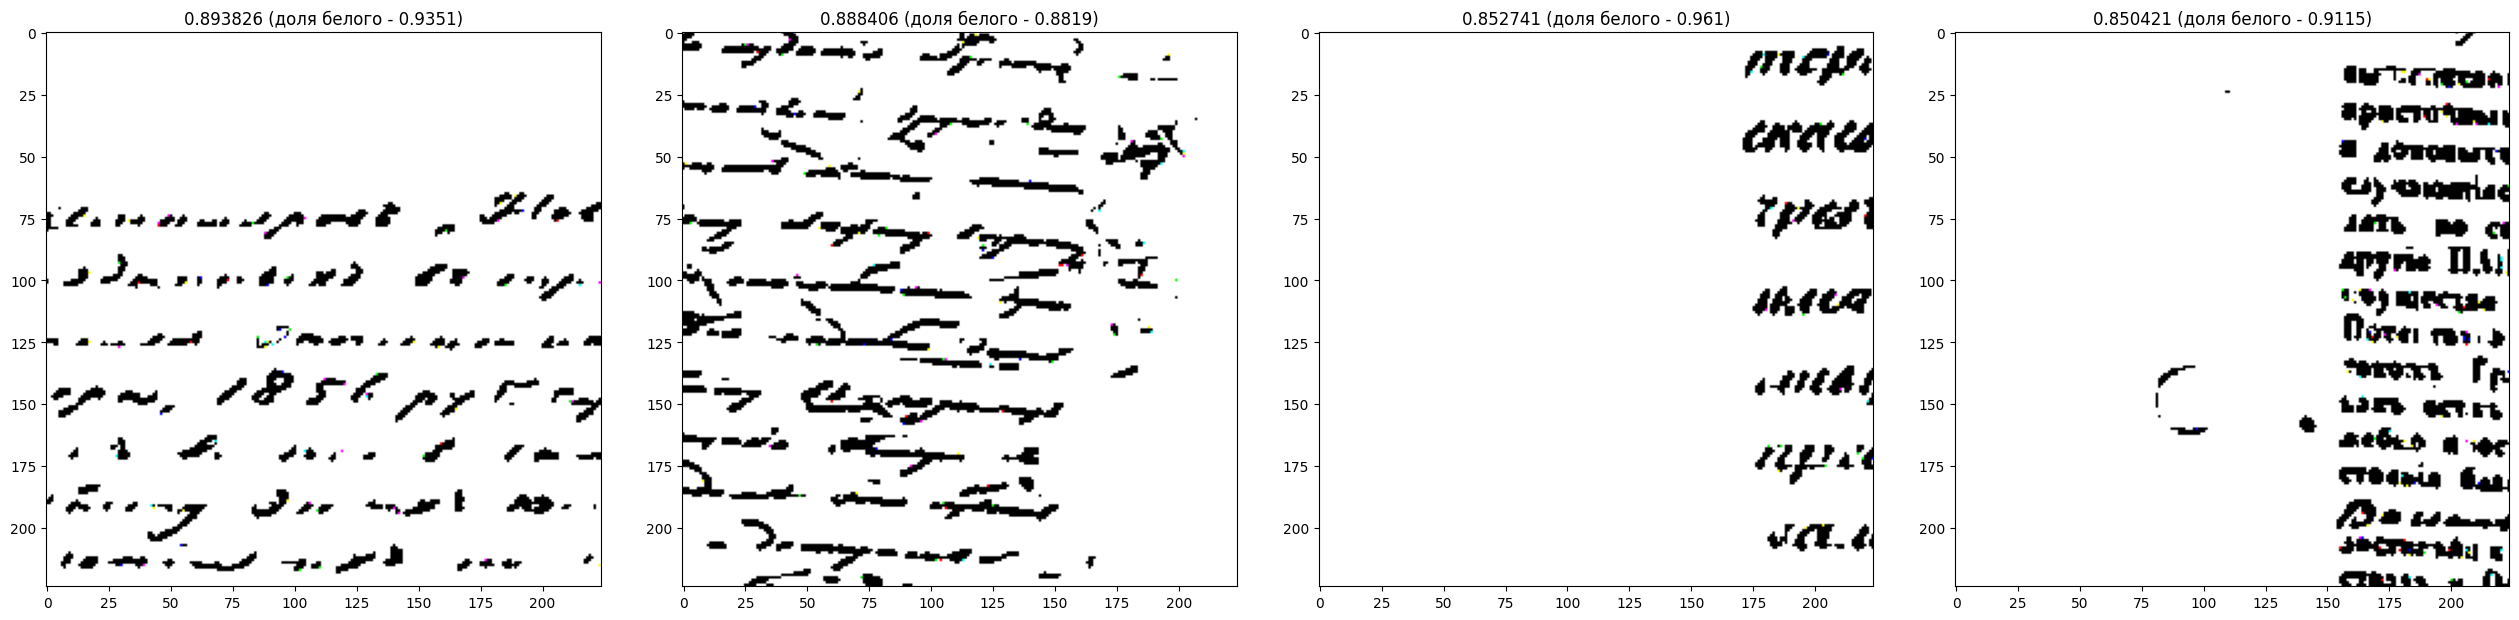

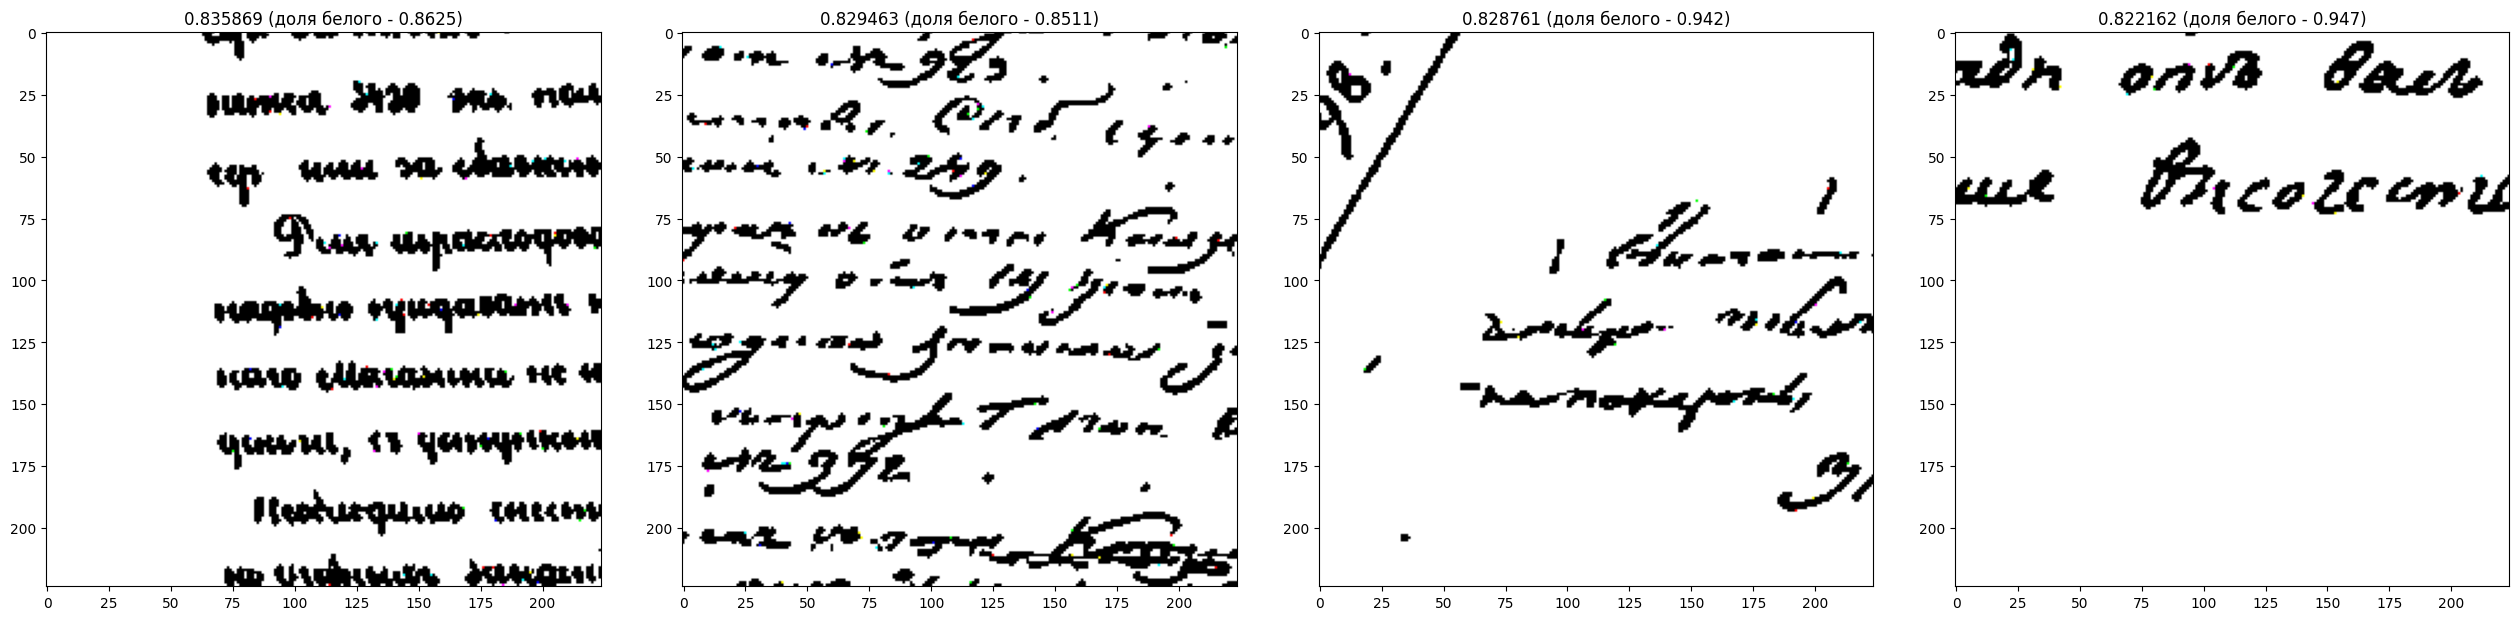

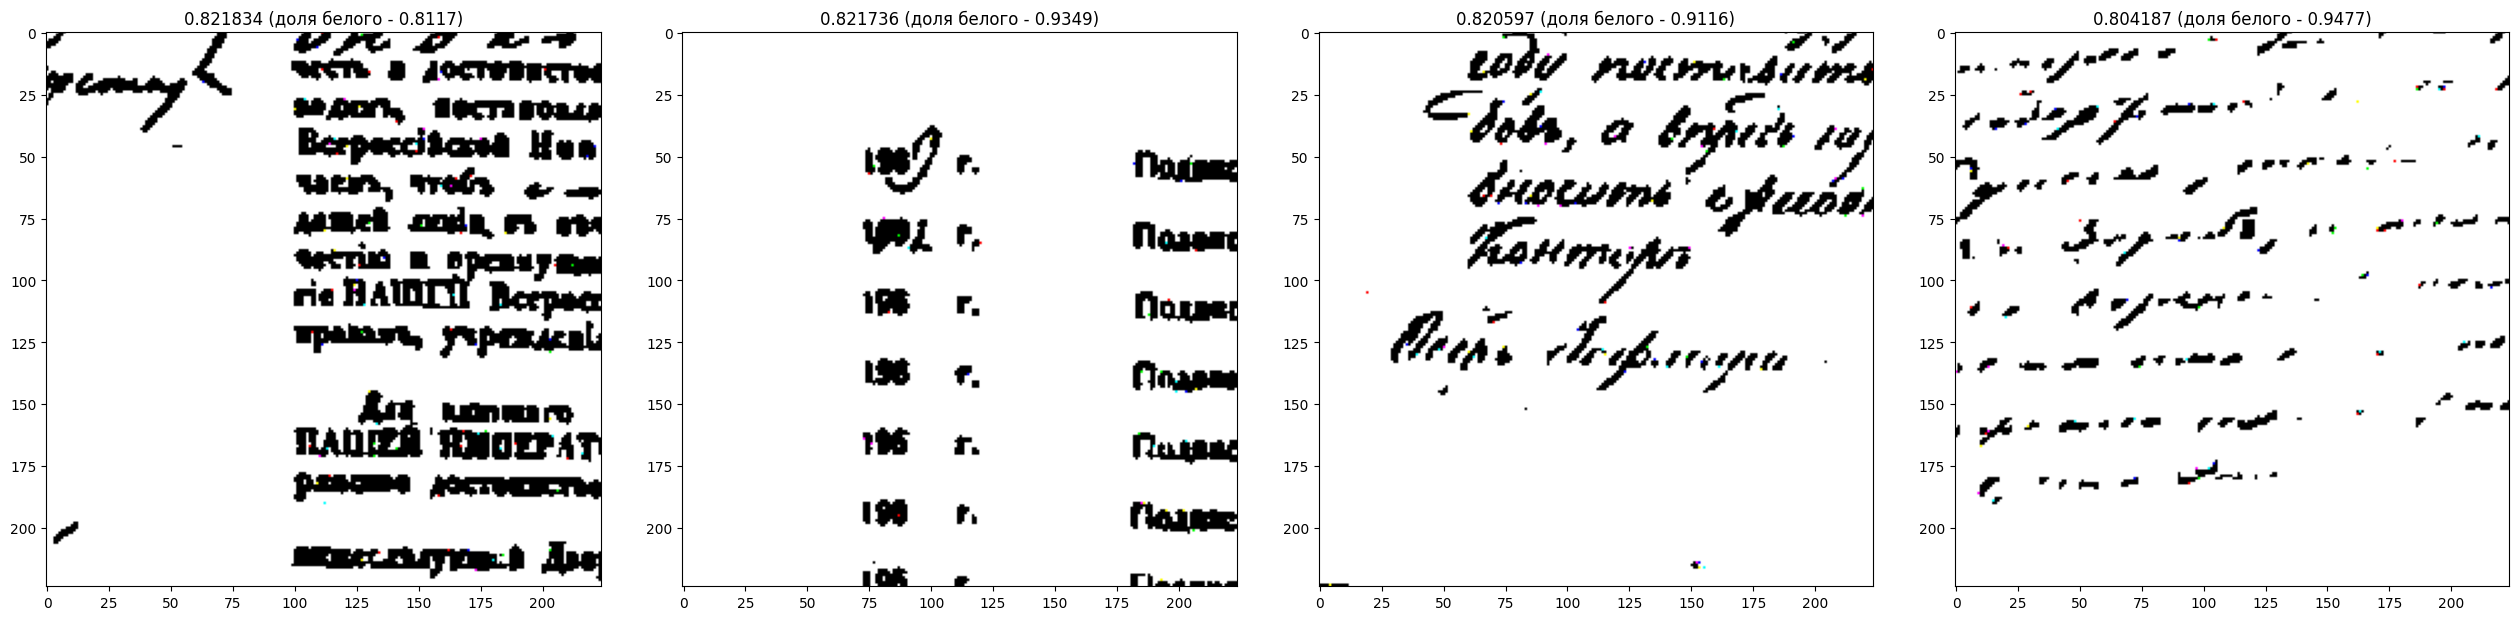

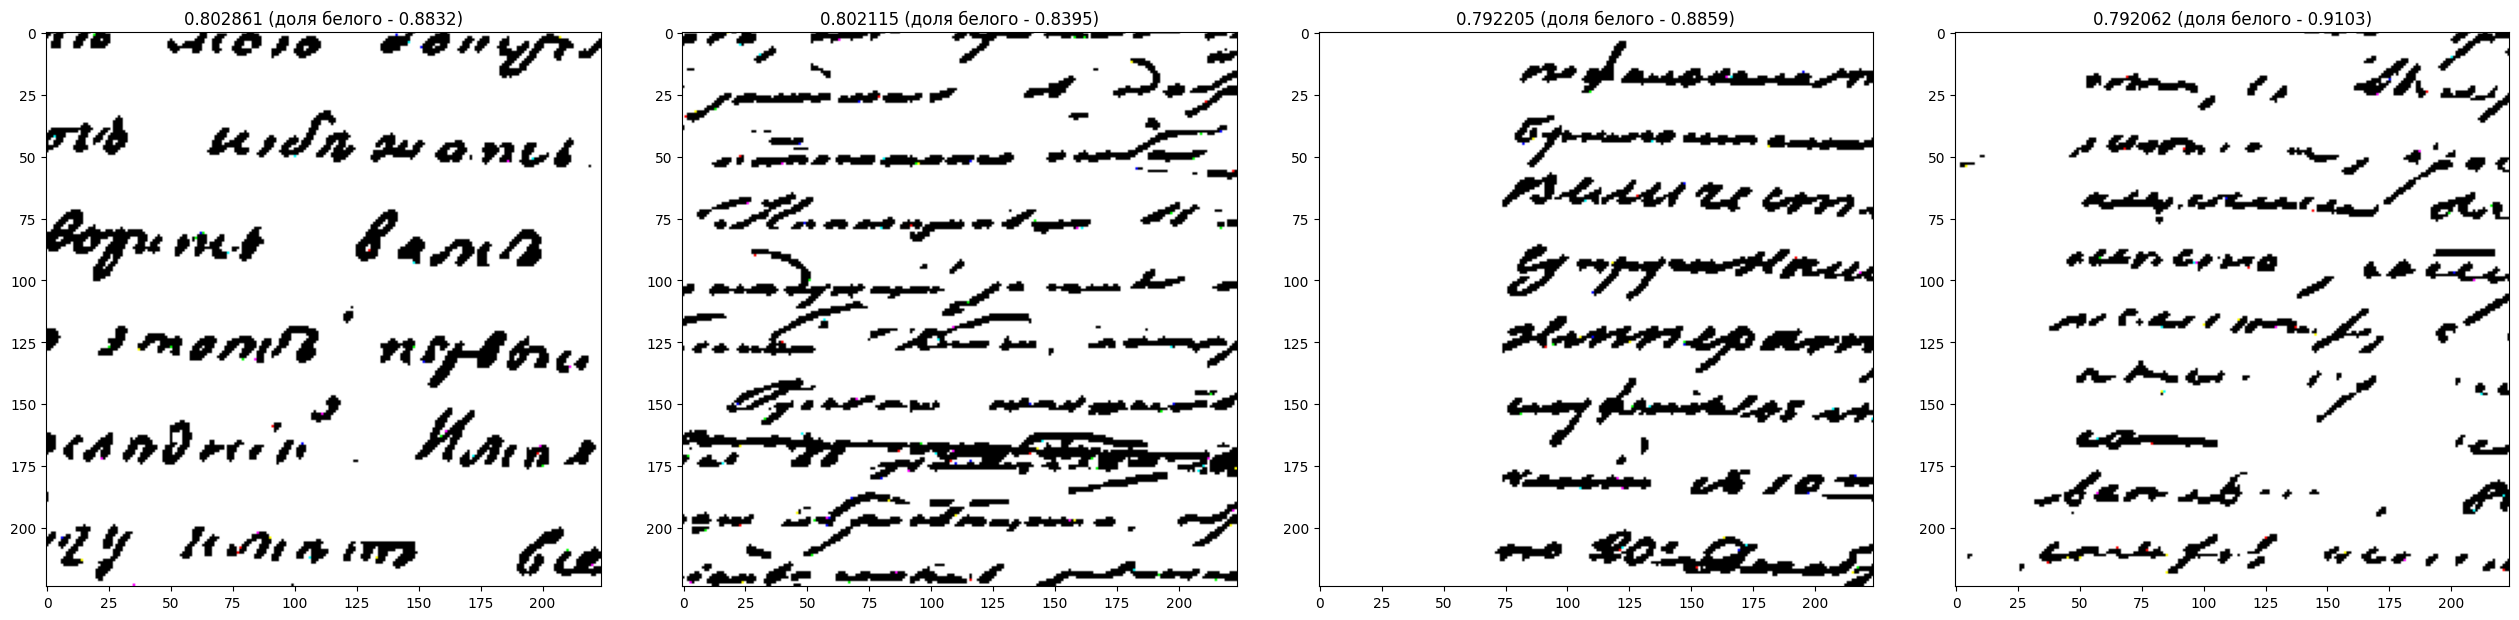

In [37]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0.79, greater = True, col = 24, sort = True)

In [38]:
# img = pos_dataset[0][0]
# img.shape

In [39]:
# s = set()
# for i in range(300):
#     for j in range(300):
#         s |= {tuple(img[:, i, j].tolist())}

# s

In [40]:
# x, num = np.unique(img.max(dim = 0)[0], return_counts = True)
# x, num

In [41]:
# plt.figure(figsize=(20, 20))

# plt.imshow(np.transpose(img, (1, 2, 0)))

# on the entire dataset

In [42]:
y_pred, _, y_prob, X = show_result(model, neg_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.

In [43]:
y_pred, _, y_prob, X = show_result(model, pos_dataset, 0, greater = True, col = 224, sort = True)

Output hidden; open in https://colab.research.google.com to view.